# Come si misura un picco

La determinazione dei parametri di un picco che si sovrappone ad un segnale di fondo è un problema tipico della fisica. Del picco può essere interessante misurare la posizione, la larghezza e l'ampiezza. Tutti questi parametri si possono determinare simultaneamente con un fit.

In [26]:
from matplotlib import pyplot as plt
import numpy as np
from iminuit import Minuit
from iminuit.cost import LeastSquares
import math
from scipy.stats import expon, norm, poisson

Definiamo i modelli funzionali per il fondo ed il segnale. In questo caso usiamo un'esponenziale ed una gaussiana con parametri variabili.

Le abbondanze relative di segnale e fondo sono anch'esse determinate da parametri.

In [27]:
def bkg_pdf(x, l):
    return np.exp(-x/l)/l
def sig_pdf(x, mu, sigma):
    return np.exp(-((x - mu)/sigma)**2/2)/math.sqrt(2*math.pi*sigma**2)
def bkg_model(x, b, l):
    return b*bkg_pdf(x, l)
def sig_model(x, s, mu, sigma):
    return s*sig_pdf(x, mu, sigma)
def fit_model(x, b, l, s, mu, sigma):
    return bkg_model(x, b, l) + sig_model(x, s, mu, sigma)

Definiamo i parametri "veri" che useremo per generare casualmente un campione secondo la distribuzione voluta.

<span style="color:red">Nota: in un esperimento vero non sappiamo i valori veri! Questa opportunità c'è solo in una simulazione.</span>

In [3]:
sig_true, bkg_true = 80, 200
l_true = 10
mu_true, sigma_true = 10, 1.5

Generiamo un campione secondo la distribuzione teorica. Questo rappresenterà il nostro campione di dati.

<span style="color:red">Nota: in un esperimento reale e non simulato, molto spesso nemmeno la distribuzione teorica non è nota, in particolare per il fondo!</span>

In [28]:
n_sig = poisson(sig_true).rvs()
n_bkg = poisson(bkg_true).rvs()

In [29]:
n_sig, n_bkg

(88, 194)

In [32]:
sig_x = norm(loc=mu_true, scale=sigma_true).rvs(n_sig)
bkg_x = expon(scale=l_true).rvs(n_bkg)
evt_x = np.concatenate([sig_x, bkg_x])
np.random.shuffle(evt_x)

Distribuiamo i valori generati su un istogramma

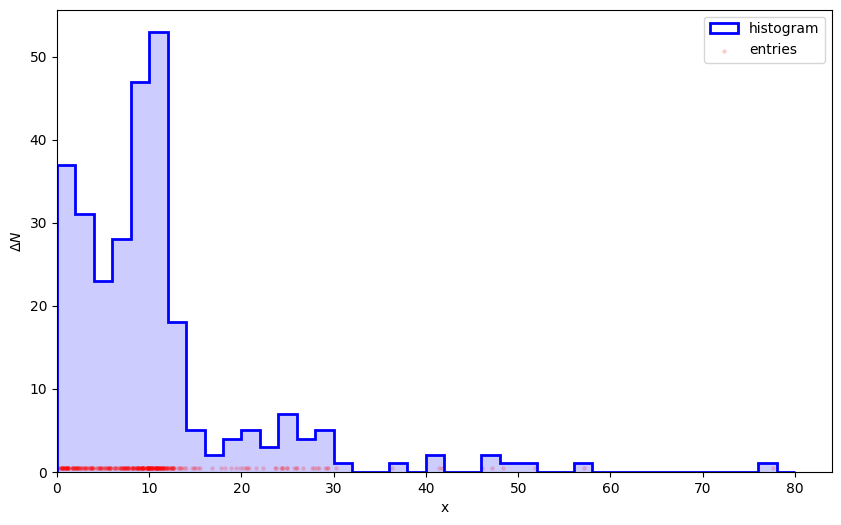

In [34]:
fig, ax = plt.subplots(figsize=(10,6))
n_bins = 40
x_range = (0, 80)
data_y, bins, patches = ax.hist(evt_x, n_bins, range=x_range, density=False, 
    histtype=u'step', edgecolor='b', linewidth=2, label='histogram')
ax.hist(evt_x, n_bins, range=x_range, density=False, color='b', alpha=0.2)
ax.scatter(evt_x, np.full_like(evt_x, 0.5), marker='o', color='r', s=10, alpha=0.2, linewidth=0, label='entries')
plt.xlabel('x')
plt.ylabel('$\Delta N$')
plt.xlim(0)
plt.legend()
plt.show()

Siddividiamo l'intervallo in $x$ in un certo numero di *bin*.

In [35]:
bins

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
       26., 28., 30., 32., 34., 36., 38., 40., 42., 44., 46., 48., 50.,
       52., 54., 56., 58., 60., 62., 64., 66., 68., 70., 72., 74., 76.,
       78., 80.])

Calcoliamo il centro di ogni bin

In [36]:
data_x = (bins[1:] + bins[:-1])/2
print(data_x)
delta_x = bins[1:] - bins[:-1]
print("𝚫x = {:.2f}".format(delta_x[0]))

[ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19. 21. 23. 25. 27. 29. 31. 33. 35.
 37. 39. 41. 43. 45. 47. 49. 51. 53. 55. 57. 59. 61. 63. 65. 67. 69. 71.
 73. 75. 77. 79.]
𝚫x = 2.00


Se ci fosse necessario, possiamo definiree i valori attesi del numero di eventi in ciascun bin:

In [37]:
data_y0 = fit_model(data_x, bkg_true, l_true, sig_true, mu_true, sigma_true)

Per ciascun bin, se il numero di conteggi è distribuito in maniera poissoniana, possiamo assumere un errore pari a $\sqrt{n}$.

In [38]:
data_yerr = np.sqrt(data_y)
print(data_y)
print(data_yerr)

[37. 31. 23. 28. 47. 53. 18.  5.  2.  4.  5.  3.  7.  4.  5.  1.  0.  0.
  1.  0.  2.  0.  0.  2.  1.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.]
[6.08276253 5.56776436 4.79583152 5.29150262 6.8556546  7.28010989
 4.24264069 2.23606798 1.41421356 2.         2.23606798 1.73205081
 2.64575131 2.         2.23606798 1.         0.         0.
 1.         0.         1.41421356 0.         0.         1.41421356
 1.         1.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.        ]


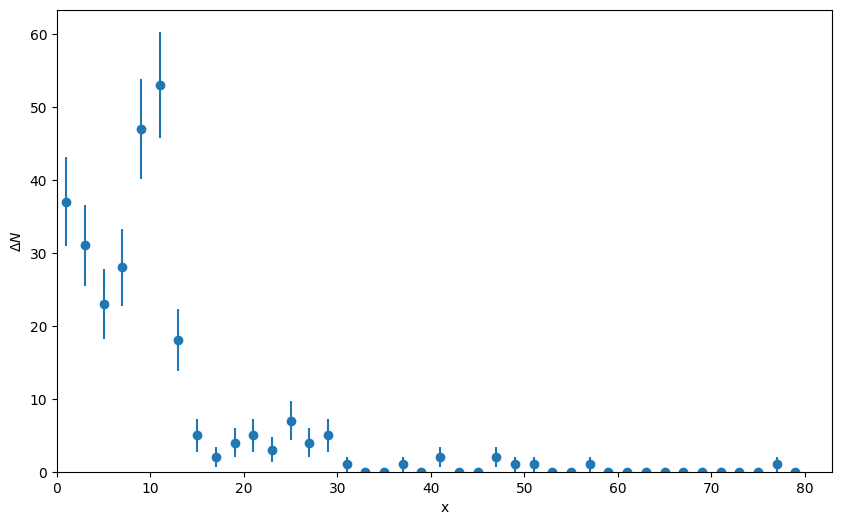

In [39]:
plt.figure(figsize=(10,6))
plt.errorbar(data_x, data_y, data_yerr, fmt="o")
plt.xlabel('x')
plt.ylabel('$\Delta N$')
plt.ylim(0)
plt.xlim(0)
plt.show()

Facciamo un fit di minimo $\chi^2$ ai dati.

<span style="color:red">Attenzione: dobbiamo evitare i *bin* dove il conteggio è nullo!</span>

Nota: Il nostro modello prevede:

$\displaystyle \mathrm{pdf}(x) = \frac{\mathrm{d}P}{\mathrm{d}x} \simeq \frac{1}{N}\frac{\Delta N}{\Delta x}$

Ma:

$\displaystyle f(x) = N\frac{\mathrm{d}P}{\mathrm{d}x} \simeq \frac{\Delta N}{\Delta x}$

Quindi:

$\Delta N(x) \simeq f(x){\Delta x}$


In [44]:
def fit_model_binned(x, b, l, s, mu, sigma):
    return fit_model(x, b, l, s, mu, sigma)*delta_x[data_y>0]
least_squares_model = LeastSquares(data_x[data_y>0], data_y[data_y>0], data_yerr[data_y>0], fit_model_binned)
m = Minuit(least_squares_model, 250, 10, 60, 10, 1.5, name=("B", "$\lambda$", "S", "$\mu$", "$\sigma$"))

In [41]:
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 22.73 (χ²/ndof = 1.3)      │              Nfcn = 111              │
│ EDM = 1.16e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ B    │    168    │    17     │            │            │         │         │       │
│ 1 │ 𝜆    │    8.2    │    1.0    │            │            │         │         │       │
│ 2 │ S    │    94     │    14     │            │            │         │         │       │
│ 3 │ 𝜇    │   10.13   │   0.27    │            │            │         │         │       │
│ 4 │ 𝜎    │   1.64    │   0.23    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────────┐
│   │       B       𝜆       S       𝜇       𝜎 │
├───┼─────────────────────────────────────────┤
│ B │     271     3.3 -0.10e3    0.78   -1.38 │
│ 𝜆 │     3.3   0.995    -2.3   -0.02   -0.03 │
│ S │ -0.10e3    -2.3     187   -0.78    1.33 │
│ 𝜇 │    0.78   -0.02   -0.78  0.0727   -0.03 │
│ 𝜎 │   -1.38   -0.03    1.33   -0.03  0.0532 │
└───┴─────────────────────────────────────────┘

In [42]:
m.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 22.73 (χ²/ndof = 1.3)      │              Nfcn = 612              │
│ EDM = 1.16e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ B    │    168    │    16     │    -17     │     16     │         │         │       │
│ 1 │ 𝜆    │    8.2    │    1.0    │    -1.0    │    1.1     │         │         │       │
│ 2 │ S    │    94     │    14     │    -14     │     14     │         │         │       │
│ 3 │ 𝜇    │   10.13   │   0.27    │   -0.28    │    0.26    │         │         │       │
│ 4 │ 𝜎    │   1.64    │   0.23    │   -0.23    │    0.24    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │           B           │           𝜆           │           S           │           𝜇           │           𝜎           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │    -17    │    16     │   -1.0    │    1.1    │    -14    │    14     │   -0.28   │   0.26    │   -0.23   │   0.24    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───┬─────────────────────────────────────────┐
│   │       B       𝜆       S       𝜇       𝜎 │
├───┼─────────────────────────────────────────┤
│ B │     271     3.3 -0.10e3    0.78   -1.38 │
│ 𝜆 │     3.3   0.995    -2.3   -0.02   -0.03 │
│ S │ -0.10e3    -2.3     187   -0.78    1.33 │
│ 𝜇 │    0.78   -0.02   -0.78  0.0727   -0.03 │
│ 𝜎 │   -1.38   -0.03    1.33   -0.03  0.0532 │
└───┴─────────────────────────────────────────┘

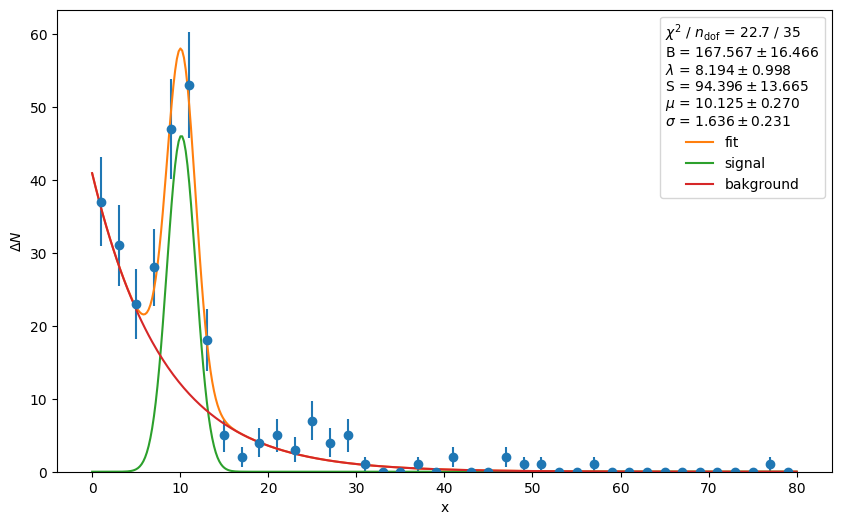

In [43]:
plt.figure(figsize=(10, 6))
plt.errorbar(data_x, data_y, data_yerr, fmt="o")
data_x_f = np.linspace(bins[0], bins[-1], 400)
#nota: la rappresentazione come curva va bene solo se 𝚫x non varia bin per bin!
data_y_f = fit_model(data_x_f, *m.values)*delta_x[0]
bkg_y_f = bkg_model(data_x_f, *m.values[:2])*delta_x[0]
sig_y_f = sig_model(data_x_f, *m.values[2:])*delta_x[0]
plt.plot(data_x_f, data_y_f, label="fit")
plt.plot(data_x_f, sig_y_f, label="signal")
plt.plot(data_x_f, bkg_y_f, label="bakground")
plt.xlabel('x')
plt.ylabel('$\Delta N$')
fit_info = [ f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(data_x) - m.nfit}" ]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
plt.legend(title="\n".join(fit_info))
plt.ylim(0)
plt.show()

Grafichiamo i **residui** insieme al fit:

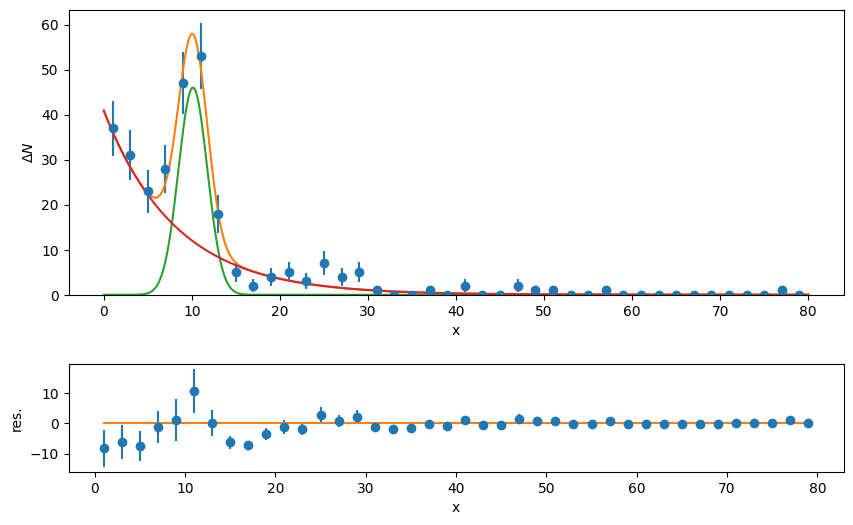

In [45]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(8, 1)
ax0 = plt.subplot(gs[:5, :])
ax1 = plt.subplot(gs[6:, :])
ax0.errorbar(data_x, data_y, data_yerr, fmt="o")
ax0.plot(data_x_f, data_y_f, label="fit")
ax0.plot(data_x_f, sig_y_f, label="signal")
ax0.plot(data_x_f, bkg_y_f, label="bakground")
ax0.set_xlabel('x')
ax0.set_ylabel('$\Delta N$')
data_fit = fit_model(data_x, *m.values)*delta_x[0]
ax1.errorbar(data_x, (data_y - data_fit), data_yerr, fmt="o")
ax1.plot([data_x[0], data_x[-1]], [0,0])
ax1.set_xlabel('x')
ax1.set_ylabel('res.')
ax0.set_ylim(0)
plt.show()

# Stima dei parametri e correlazione

<span style="color:red">Attenzione:</span> se nel fit avessimo usato, come modello per il picco, per semplicità:
        
$\displaystyle f(x) = p_0 \exp\left(-\frac{(x-p_1)^2}{2 p_3^3}\right)$

$f(x)$ rappresenta il numero **atteso** di conteggio nel bin centrato intorno ad $x$ ed è confrontato con il conteggio osservato $y$.

Il numero totale di conteggi dovuto al segnale si ottiene come:

$\displaystyle S = \sum_{i=1}^{b} f(x_i) = p_0 \sum_{i=1}^{b} \exp\left(-\frac{(x_i-p_1)^2}{2 p_3^3}\right)$

Avendo invece definito:

$\displaystyle f(x) = \frac{p_0^\prime}{\sqrt{2\pi p_3^2}} \exp\left(-\frac{(x-p_1)^2}{2 p_3^3}\right)\Delta x$

(tutto è più semplice se $\Delta x=1$) abbiamo:

$\displaystyle S = \sum_{i=1}^{b} f(x_i) = p_0^\prime \sum_{i=1}^{b} \frac{1}{\sqrt{2\pi p_3^2}}\exp\left(-\frac{(x_i-p_1)^2}{2 p_3^3}\right)\Delta x \simeq
p_0^\prime \int_{-\infty}^{+\infty} \frac{1}{\sqrt{2\pi p_3^2}}\exp\left(-\frac{(x-p_1)^2}{2 p_3^3}\right)\,\mathrm{d} x =
p_0^\prime
$

Per valutare l'area del picco sarà quindi necessario passare da $p_0$ a $p_0^\prime=S = p_0\Delta x/{2\pi p_3^2}$. Questo comporta la propagazione degli errori tenendo conto del termine di correlazione tra $p_0$ e $p_3$ che potrebbe non risultare trascurabile.

In generale, ogni volta che è possibile, conviene sempre usare una parametrizzazione nella quale i **parametri di interesse** siano esplicitati come parametri del fit, in modo da evitare la propagazione degli errori che potrebbe introdurre complicazioni.

# Altri metodi approssimati

In alcune applicazioni, per evitare il fit, si stima la quantità del fondo delle *sideband*, ossia le aree laterali al picco, dove la quantità di segnale è trascurabile. Si interpola nella regione centrale, e si sottrae questa stima al numero di eventi entro una finestra dove si trova il segnale.

Questa stima in genere risulta meno precisa di quanto si ottiene direttamente dal fit che abbiamo visto.

# Fit *Unbinned*

Possiamo considerare, come campione di dati del fit, i singoli valori, $x_1, \cdots, x_n$ anziché o contenuti dei singoli bini, $n_1, \cdots, n_b$.

Per ciascun valore $x_i$ possiamo calcolare il valore della PDF, dati i valori dei parametri incogniti. La funzione di verosimiglianza totale sarà il prodotto delle singole PDF. Abbiamo usato lo stesso approccio per arrivare alla stima della media pesata.

$\displaystyle p(x_1, \cdots, x_n;\theta) = \prod_{i=1}^n p(x_i;\theta)$

## Funzione di verosimiglianza estesa

Inoltre, il numero totale di eventi osservati $n$ può darci informazione sul numero atteso di eventi di segnale $s$ e di fondo $b$, perché $n$ è distribuito secondo una poissoniana con valore atteso $s+b$. Possiamo moltiplicare la funzione di verosimiglianza definita sopra per un termine poissoniano e tenere conto di $n$. Questa definizione prende il nome di funzione di verosimiglianza estesa (*extended likelihood function*).

$\displaystyle p(x_1, \cdots, x_n;\theta) = 
\frac{e^{-\nu(\theta)}\nu(\theta)^n}{n!}
\prod_{i=1}^n p(x_i;\theta)$

Consideriamo la nostra PDF che è una mistura di segnale e di fondo:

$p(x;\theta) = w_s f_s(x;\theta) + w_b f_b(x;\theta)$

dove:

$\displaystyle w_s = \frac{s}{s+b}$

$\displaystyle w_b = \frac{b}{s+b}$

Assumiamo anche, per semplicità, che $s$ e $b$ non dipendano da $\theta$.

La funzione di verosimiglianza diventa:


$\displaystyle p(x_1, \cdots, x_n;\theta) = 
\frac{e^{-(s+b)}(s+b)^n}{n!}
\prod_{i=1}^n \left(\frac{s}{s+b} f_s(x;\theta) + \frac{b}{s+b} f_b(x;\theta)\right) =\\
\displaystyle \frac{e^{-(s+b)}(s+b)^n}{n!}
\prod_{i=1}^n \frac{sf_s(x;\theta) + b f_b(x;\theta)}{s+b}
$

Quindi: 

$\displaystyle p(x_1, \cdots, x_n;\theta) = 
\frac{e^{-(s+b)}}{n!}
\prod_{i=1}^n \left[sf_s(x;\theta) + b f_b(x;\theta)\right]
$

Sarà più comodo minimizzare $-\log p$ oppure $-2\log p$:


$\displaystyle -\log p(x_1, \cdots, x_n;\theta) = 
s + b - \sum_{i=1}^n \log\left[sf_s(x;\theta) + b f_b(x;\theta)\right]
-\log n!
$

$n$ è una costante, quindi il termine $-\log n!$ può essere omesso nella minimizzazione.

Nel modulo ```iminuit``` esiste una funzione ```ExtendedUnbinnedNLL``` che tratta questi casi, ma è più istruttivo, almeno una volta, implementare la definzione esplicitamente.

Esempi di uso si trovano nel [tutorial](https://iminuit.readthedocs.io/en/stable/notebooks/cost_functions.html) sulle *cost function*.

In [46]:
def neg_log_like_fun(b, l, s, mu, sigma):
    lik = s + b
    for x in evt_x:
        lik -= math.log(fit_model(x, b, l, s, mu, sigma))
    return lik
neg_log_like_fun.errordef = Minuit.LIKELIHOOD 
m = Minuit(neg_log_like_fun, 200, 10, 80, 10, 1.5, name=("B", "$\lambda$", "S", "$\mu$", "$\sigma$"))

In [47]:
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -409.5                     │              Nfcn = 99               │
│ EDM = 5.05e-06 (Goal: 0.0001)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ B    │    195    │    17     │            │            │         │         │       │
│ 1 │ 𝜆    │   10.6    │    0.8    │            │            │         │         │       │
│ 2 │ S    │    87     │    13     │            │            │         │         │       │
│ 3 │ 𝜇    │   10.10   │   0.25    │            │            │         │         │       │
│ 4 │ 𝜎    │   1.48    │   0.21    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────────┐
│   │       B       𝜆       S       𝜇       𝜎 │
├───┼─────────────────────────────────────────┤
│ B │     282    -0.6 -0.09e3    0.81   -1.14 │
│ 𝜆 │    -0.6   0.588     0.6   -0.02    0.01 │
│ S │ -0.09e3     0.6     175   -0.81    1.14 │
│ 𝜇 │    0.81   -0.02   -0.81  0.0633   -0.02 │
│ 𝜎 │   -1.14    0.01    1.14   -0.02  0.0454 │
└───┴─────────────────────────────────────────┘

In [48]:
m.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -409.5                     │              Nfcn = 461              │
│ EDM = 5.05e-06 (Goal: 0.0001)    │            time = 0.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ B    │    195    │    17     │    -16     │     17     │         │         │       │
│ 1 │ 𝜆    │   10.6    │    0.8    │    -0.7    │    0.8     │         │         │       │
│ 2 │ S    │    87     │    13     │    -13     │     14     │         │         │       │
│ 3 │ 𝜇    │   10.10   │   0.25    │   -0.26    │    0.25    │         │         │       │
│ 4 │ 𝜎    │   1.48    │   0.21    │   -0.20    │    0.23    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │           B           │           𝜆           │           S           │           𝜇           │           𝜎           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │    -16    │    17     │   -0.7    │    0.8    │    -13    │    14     │   -0.26   │   0.25    │   -0.20   │   0.23    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───┬─────────────────────────────────────────┐
│   │       B       𝜆       S       𝜇       𝜎 │
├───┼─────────────────────────────────────────┤
│ B │     282    -0.6 -0.09e3    0.81   -1.14 │
│ 𝜆 │    -0.6   0.588     0.6   -0.02    0.01 │
│ S │ -0.09e3     0.6     175   -0.81    1.14 │
│ 𝜇 │    0.81   -0.02   -0.81  0.0633   -0.02 │
│ 𝜎 │   -1.14    0.01    1.14   -0.02  0.0454 │
└───┴─────────────────────────────────────────┘

## Importante

Quando confrontiamo una PDF ad un istogramma, dobbiamo ricordare che la PDF è:

$\displaystyle f(x) = \frac{\mathrm{d}P}{\mathrm{d}x}$

e quindi il numero atteso di conteggi in un bin di ampiezza $\Delta x$ sarà:

$\displaystyle \Delta N = f(x) \Delta x$

In questo esempio, se $\Delta x$ vale 1, nelle unità di misura usate, il risultato numerico non cambia, ma se cambiamo *binning* il valore di $\Delta x$ diventa importante.

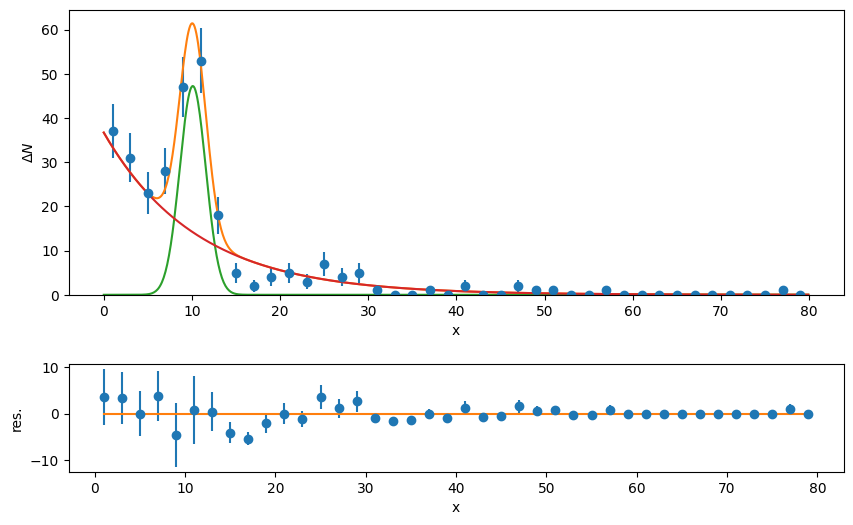

In [49]:
import matplotlib.gridspec as gridspec
data_x_f = np.arange(0, bins[-1], 0.1)
data_y_f = fit_model(data_x_f, *m.values)*delta_x[0]
bkg_y_f = bkg_model(data_x_f, *m.values[:2])*delta_x[0]
sig_y_f = sig_model(data_x_f, *m.values[2:])*delta_x[0]
plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(8, 1)
ax0 = plt.subplot(gs[:5, :])
ax1 = plt.subplot(gs[6:, :])
ax0.errorbar(data_x, data_y, data_yerr, fmt="o")
ax0.plot(data_x_f, data_y_f, label="fit")
ax0.plot(data_x_f, sig_y_f, label="signal")
ax0.plot(data_x_f, bkg_y_f, label="bakground")
ax0.set_xlabel('x')
ax0.set_ylabel('$\Delta N$')
ax1.errorbar(data_x, data_y - fit_model(data_x, *m.values)*delta_x[0], data_yerr, fmt="o")
ax1.plot([data_x[0],data_x[-1]], [0,0])
ax1.set_xlabel('x')
ax1.set_ylabel('res.')
ax0.set_ylim(0)
plt.show()

### Quando usare fit unbinned e quando usare fit binned

In generale, i fit *unbinned* sono più precisi, e non soffrono del problema di bin con numero di conteggio molto piccolo (che non seguono l'approssimazione gaussiana) o addirittura nullo.
Però richiedono più tempo di calcolo per determinare la funzione di verosimiglianza se il campione ha un numero $n$ di elementi significativamente maggiore del numero di bin $b$.

In generale, trasformare la distribuzione in un istogramma fa perdere informazione. In particolare, la presenza di picchi che vengono "ristretti" all'interno di uno o pochi bin fanno perdere precisione sulla determinazione della larghezza del picco o di altri parametri che ne caratterizzano la forma.

Se il campione è molto grande, però, un fit unbinned può essere intrattabile.

La situazione più difficile può essere uno spettro che "cade" per diversi ordini di grandezza sul quale è (o potrebbe essere presente) un picco nella parte in cui ci sono pochi eventi. Questo è il caso di una ricerca di nuove particelle ad LHC. In queste situazioni, va valutato con attenzione l'approccio migliore da usare, caso per caso.
